# Total Correation with Iterative Gaussianization

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))

# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# logging
import tqdm

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Total Correlation

# Simple Dataset

In [3]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# %%wandb
# get data
seed = 123
n_samples = 5_000
n_features = 2
noise = 0.05

X, y = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=seed)

data = X[:]

In [4]:
# initialize histogram transformation
n_samples = X.shape[0]
nbins = int(np.sqrt(n_samples))
support_extension = 10
precision = 1_000
alpha = 1e-5

# initialize total correlation transformation
zero_tolerance = 20

In [6]:

%%time

X_g, info_loss = rbig_total_correlation(
    X=X.block_until_ready(),
    zero_tolerance=zero_tolerance,
    return_all=True
)

CPU times: user 11.3 s, sys: 423 ms, total: 11.8 s
Wall time: 10.9 s


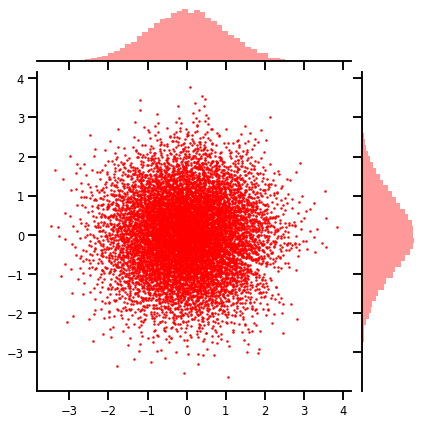

In [7]:
sns.jointplot(X_g[:, 0], X_g[:, 1], color="red", s=1)

In [8]:
print(info_loss.shape)

(38,)


In [9]:
base = 2
tc = np.sum(info_loss) * np.log(base)
print(f"RBIG TC: {tc}")

RBIG TC: 0.7492179877275595


In [10]:
%%time

tc = rbig_total_correlation(
    X=X.block_until_ready(),
    zero_tolerance=zero_tolerance,
    return_all=False
)
print(f"RBIG TC: {tc:.5f}")

RBIG TC: 0.74922
CPU times: user 10.6 s, sys: 42.2 ms, total: 10.7 s
Wall time: 10.3 s


## High-Dimensional Toy Data

In [4]:
from sklearn.utils import check_random_state

#Parameters
n_samples = 10_000
d_dimensions = 5

seed = 123

rng = check_random_state(seed)

# Generate random normal data
data_original = rng.randn(n_samples, d_dimensions)

# Generate random Data
A = rng.rand(d_dimensions, d_dimensions)

data = data_original @ A

# covariance matrix
C = A.T @ A
vv = onp.diag(C)

# closed Form
tc_original = onp.log(onp.sqrt(vv)).sum() - 0.5 * onp.log(onp.linalg.det(C))

print(f"TC: {tc_original:.4f}")

TC: 5.9477


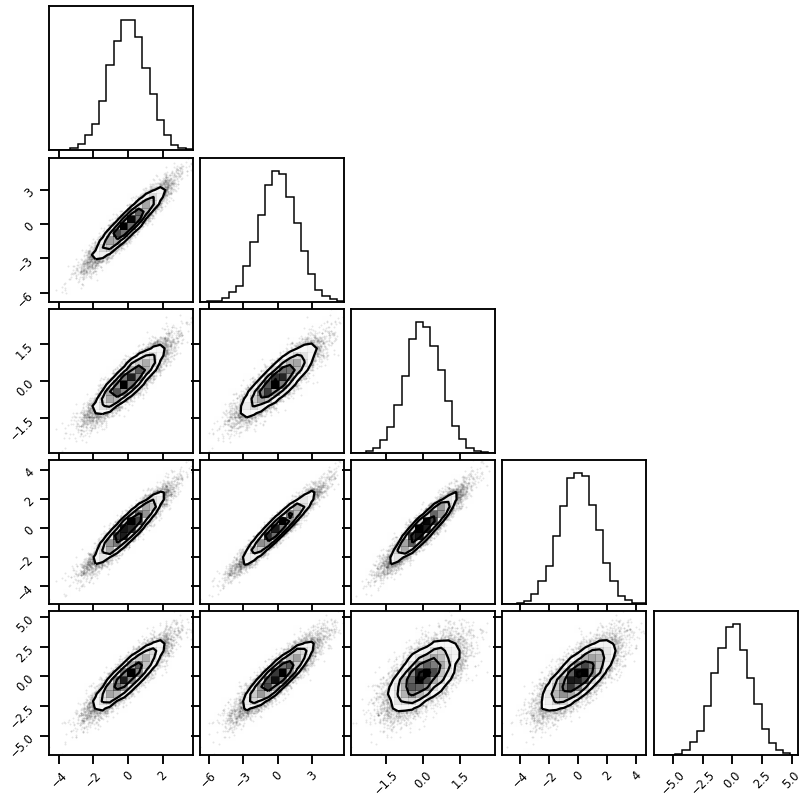

In [5]:
import corner

fig = corner.corner(data, hist_factor=2)

## RBIG Model

In [22]:
from rbig_jax.information.entropy import init_marginal_histogram_entropy
import jax.numpy as jnp
X = jnp.array(data, dtype=np.float64)
nbins = int(jnp.sqrt(X.shape[0]))
H_x = init_marginal_histogram_entropy(nbins=nbins)(X).sum()

In [23]:
H_x

DeviceArray(8.03471298, dtype=float64)

In [29]:
from rbig_jax.models import RBIG
import jax.numpy as jnp

X = jnp.array(data, dtype=np.float64)

# a lot of parameters...
support_extension = 20
precision = 100
eps = 1e-5
method = "kde"
# Histogram specific params
nbins = int(jnp.sqrt(X.shape[0]))
alpha = 1e-5
# KDE specific params
bw = "scott"

# info reduction loss parameters
max_layers = 250
zero_tolerance = 10
p = 0.25

# initialize the max layers parameters
verbose = True
n_layers_remove = 50
interval = 10

# everything (makes it fast...)
jitted = True

In [30]:
X_g, rbig_model = RBIG(
    X=X,
    support_extension=support_extension,
    method=method,
    precision=precision,
    alpha=alpha,
    nbins=nbins,
    bw=bw,
    eps=eps,
    max_layers=max_layers,
    zero_tolerance=zero_tolerance,
    p=p,
    verbose=verbose,
    n_layers_remove=n_layers_remove,
    interval=interval,
    jitted=jitted,
)

Layer 10 - Cum. Info Reduction: 6.933 - Elapsed Time: 10.0437 secs
Converged at Layer: 12
Final Number of layers: 12 (Blocks: 4)
Total Time: 10.7609 secs


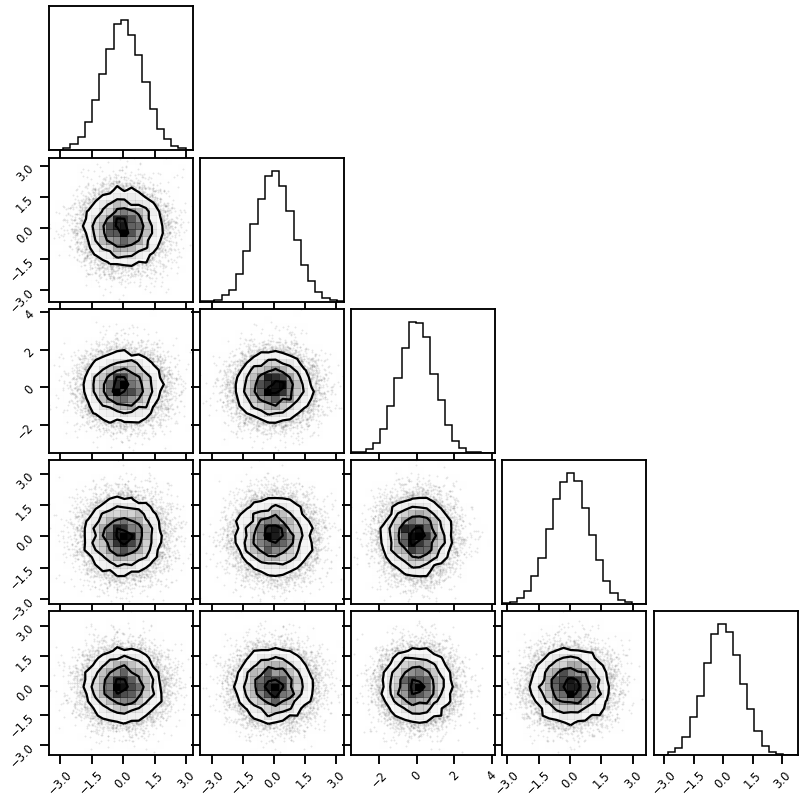

In [20]:
fig = corner.corner(X_g, hist_factor=2)

In [31]:
rbig_model.info_loss.sum()

DeviceArray(6.93331692, dtype=float64)

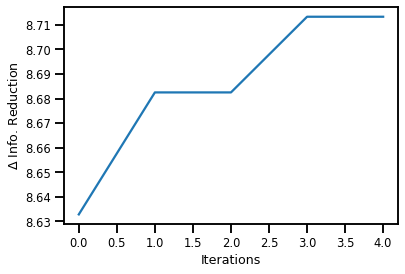

In [21]:
fig, ax = plt.subplots()
ax.plot(jnp.cumsum(rbig_model.info_loss))
ax.set(xlabel="Iterations", ylabel="$\Delta$ Info. Reduction")
plt.show()

In [12]:
%%time


X = np.array(data, dtype=np.float32)

tc = rbig_total_correlation(
    X=X.block_until_ready(),
    zero_tolerance=zero_tolerance,
    return_all=False
)
print(f"RBIG TC: {tc:.5f}")

RBIG TC: 34.75812
CPU times: user 16.8 s, sys: 7.33 s, total: 24.1 s
Wall time: 13.1 s
